In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
import scipy.spatial as spat
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import imageio
import matplotlib.cm as cm

In [2]:
def build_honeycomb(n,m, pitch):
    a_1 = np.array([3*pitch/2, np.sqrt(3)*pitch/2])
    a_2 = np.array([3*pitch/2, -np.sqrt(3)*pitch/2])

    coord_list = []
    for j in range(m):
        for i in range(n): 
            coord_list.append(a_1*i + a_2*j)

    coord_list_shifted = coord_list + np.array([-pitch, 0])
    coord_list = np.array(coord_list)
    # print(coord_list_shifted)


    full_coord_list = np.concatenate((coord_list, coord_list_shifted), axis=0)
    centered_coord_list = full_coord_list - (n*a_1 + m*a_2)/2 + np.array([2*pitch,0])

    return centered_coord_list

# Plotting betas
def plot_betas(beta_vals, coupling, point_label, xrange=[]):
    fig1  = plt.figure(figsize=(7,7))   
    ax1 = fig1.add_subplot(111)
    if type(beta_vals) == list:
        for i,vals in enumerate(beta_vals):
            ax1.scatter(np.arange(len(vals)), vals, label=point_label[i])

    else: 
        ax1.scatter(np.arange(len(beta_vals)), beta_vals-np.mean(beta_vals), label=point_label)
    ax1.grid(axis='x', which='both')
    ax1.set_ylabel(r'$ \beta$')
    ax1.set_xlabel('Mode Index')
    if len(xrange) == 2:
        ax1.set_xlim(xrange[0],xrange[1])
    plt.legend();

# For nice plotting of eigenvectors 
def plot_coloured_chain(intensities, circ_size, circ_locations, label, ):
    """
    
    """
    fig_chain = plt.figure(figsize=(5,5))
    ax_chain = fig_chain.add_subplot(111)
    intensities = intensities/np.sum(intensities)
    circ_list = []
    norm = colors.Normalize(vmin=0, vmax=max(np.real(intensities)))
    cmap = plt.cm.get_cmap('Reds')
    cmap(norm(np.real(intensities)))

    for j in range(len(intensities)):
        #print(intensities[j])
        circ_list.append(patches.Circle((circ_locations[j][0], circ_locations[j][1]), radius=circ_size//2,
                                            color=cmap(norm(np.real(intensities[j]))),ec='black')) 

#         ax_chain.annotate(str(j), (circ_locations[j][0], circ_locations[j][1]), color='black',
#                           fontsize=10, ha='center', va='center')
   
    # plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)
    plt.title('Mode no. {:d}'.format(label), loc='left')
    plt.axis('scaled')
    plt.show()     
    return  


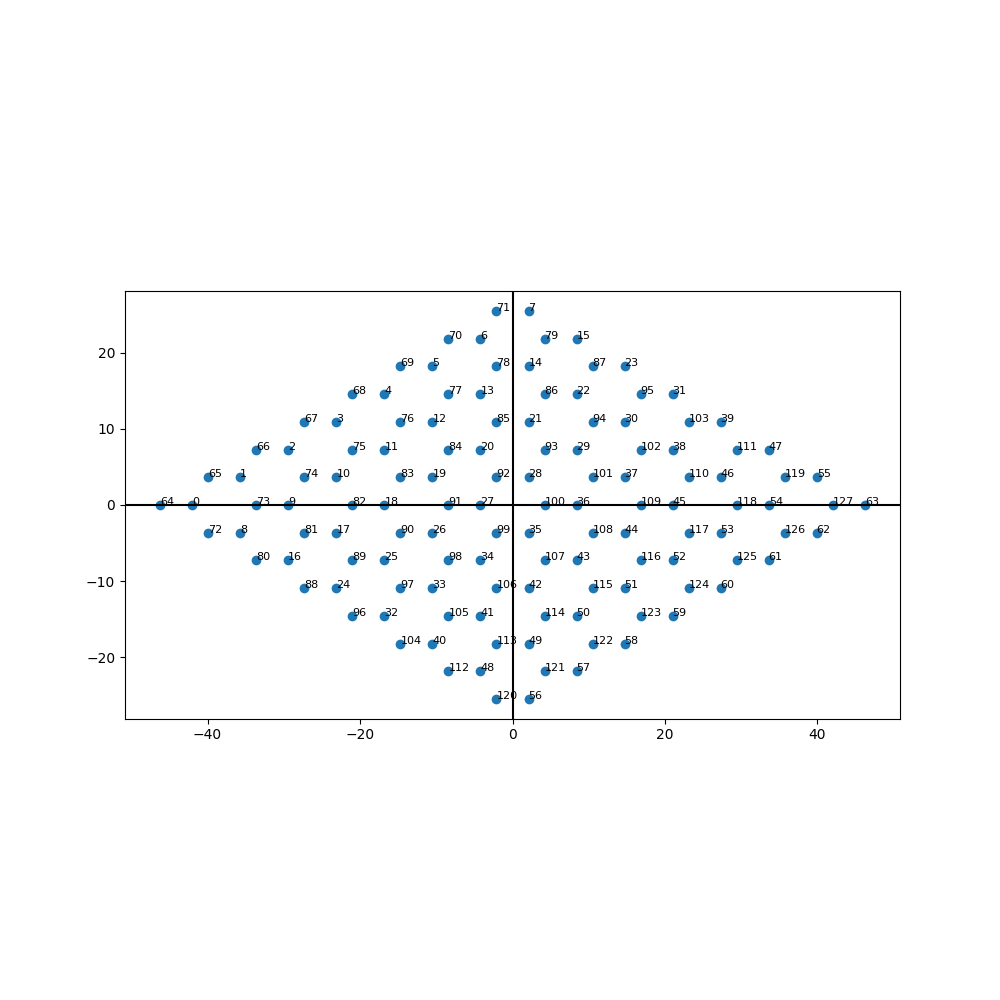

In [3]:

point_list = build_honeycomb(8, 8, 4.2)
fig_plot = plt.figure(figsize=(10,10))
ax_plot = fig_plot.add_subplot(111)
ax_plot.axhline(0, color='black')
ax_plot.axvline(0, color='black')
ax_plot.scatter(point_list[:,0], point_list[:,1])
ax_plot.set_aspect('equal')
for i in range(len(point_list)):
    # print(i, coord)
    ax_plot.annotate(str(i), (point_list[i,0], point_list[i,1]), fontsize=8)
    # for k,val in enumerate(C_MATRIX[i,:]):
    #     if np.real(val) != 0:
    #         ax_plot.arrow(point_list[i,0], point_list[i,1], point_list[k,0] - point_list[i,0] , point_list[k,1] - point_list[i,1], fc='red',ec='red' )
    #     elif np.imag(val) !=0:
    #         ax_plot.arrow(point_list[i,0], point_list[i,1], point_list[k,0] - point_list[i,0] , point_list[k,1] - point_list[i,1], fc='blue',ec='blue' )

# print(len(point_list))
# fig_plot.savefig('haldane couplings.png', dpi=300)
plt.show()


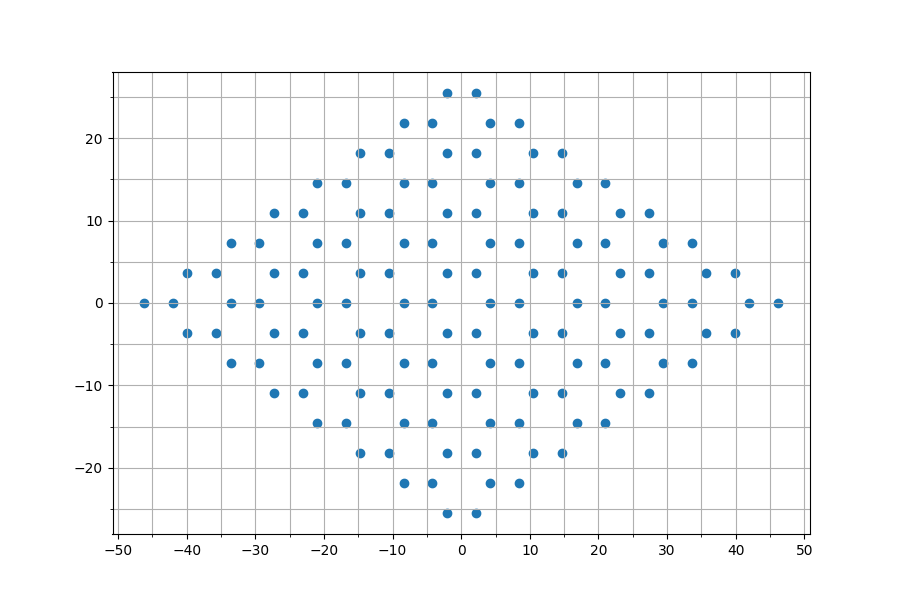

In [4]:
def onclick(event):
    pos.append([event.xdata,event.ydata])

pos = []

fig1 = plt.figure(figsize=(9,6))
ax1 = fig1.add_subplot(111)

ax1.scatter(point_list[:,0], point_list[:,1], cmap='Reds')
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.xaxis.set_major_formatter({x:.0f})
plt.grid(which='both')

fig1.canvas.mpl_connect('button_press_event', onclick)
plt.show()


In [5]:
pos = np.array(pos)
points_to_keep = np.where(cdist(point_list, pos, 'euclidean')>2, False, True )
index_to_keep = np.invert(np.any(points_to_keep, axis=1))
deformed_lattice= point_list[index_to_keep]

ValueError: XB must be a 2-dimensional array.

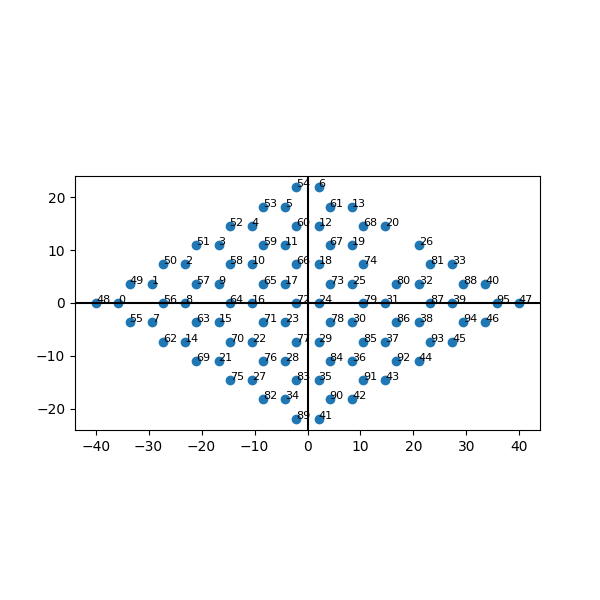

In [ ]:
fig_deformed_lattice_plot = plt.figure(figsize=(6,6))
ax_deformed_lattice_plot = fig_deformed_lattice_plot.add_subplot(111)
ax_deformed_lattice_plot.axhline(0, color='black')
ax_deformed_lattice_plot.axvline(0, color='black')
ax_deformed_lattice_plot.scatter(deformed_lattice[:,0], deformed_lattice[:,1])
ax_deformed_lattice_plot.set_aspect('equal')
for i in range(len(deformed_lattice)):
    # print(i, coord)
    ax_deformed_lattice_plot.annotate(str(i), (deformed_lattice[i,0], deformed_lattice[i,1]), fontsize=8)
# print(len(b_10_list))

plt.show()

In [6]:
def find_c_haldane(pair_list, pitch, coupling_c1, coupling_c2, M, beta_0):
    """  
        pair_lisst is the lattice coord list, pitch is the distance between nearest neighbours,
        coupling_c1 is nn coupling, coupling_c2 is nnn coupling, M is the onsite term.

        First I build a tree and find all nearest and next-nearest neighbours, splitting them 
        into separate lists to build up the coupling matrix with. 

        The angle between points (when nnn) is calculated to determine the sign of the imaginary 
        coupling. This gives the points a positive imaginary coupling if they're travelling 
        anticlockwise and negative if clockwise.
    """
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=np.complex128)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=50)
    next_and_neighbour_array = honeycomb_point_tree.query_pairs(np.sqrt(3)*(pitch+0.001), output_type = 'ndarray')
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.0001, output_type = 'ndarray')
    
    # easiest to create a list of tuples to remove any nearest neighbours from all pairs
    #  within next-nearest neighbour distance
    tup_all_list = [(i[0],i[1]) for i in next_and_neighbour_array]
    tup_nn_list = [(i[0],i[1]) for i in nearest_neighbour_array]
    tup_next_n_list = [i for i in tup_all_list if i not in tup_nn_list]

    for n in nearest_neighbour_array:
        coupling_matrix[n[0],n[1]] = coupling_c1
        coupling_matrix[n[1],n[0]] = coupling_c1

    # Logic to build up clockwise dependent phase in next-nearest neighbour coupling
    for i in tup_next_n_list:
        if i[0] >= len(pair_list)//2:
            a_or_b = -1
        else:
            a_or_b = 1
        # print(a_or_b)
        vec_between_points = pair_list[i[1]] - pair_list[i[0]]
        if vec_between_points[0] == 0:
            if vec_between_points[1] > 0:
                coupling_i = 1.0j*coupling_c2  
            elif vec_between_points[1] < 0: 
                coupling_i = -1.0j*coupling_c2 
        else:
            angle_between_points = np.arctan(vec_between_points[1]/vec_between_points[0])
            if angle_between_points > 0 and angle_between_points < 4*np.pi/10:
                coupling_i = -1.0j*coupling_c2 
            elif angle_between_points < 0 and angle_between_points > -4*np.pi/10: 
                coupling_i = 1.0j*coupling_c2 

        coupling_matrix[i[0],i[1]] = a_or_b*coupling_i
        coupling_matrix[i[1],i[0]] = -a_or_b*coupling_i       
    a_size = int(len(pair_list[:,0])/2)
    onsite = np.block([[np.eye(a_size),np.zeros((a_size, a_size))],
                       [np.zeros((a_size, a_size)),np.eye(a_size)*-1]])*M #np.eye(len(pair_list[:,0]),dtype=np.complex128)*M 
    # add_betas = np.eye(len(pair_list[:,0]),dtype=np.complex128)*beta_0
    # print(add_betas)
    full_matrix = coupling_matrix + onsite #+ add_betas
    # display(pd.DataFrame(full_matrix))
    #beta_super, eigvecs = np.linalg.eigh(full_matrix)

    return full_matrix


def vec_potential(x,y, twist_rate, beta):
    vec_A = twist_rate*beta*np.array([y,-x])
    return vec_A

def build_onsite(beta_straight, twist, coord_pairs):
    distance_to_each_core = np.array([round(np.sqrt(i**2 + j**2),4) for i,j in coord_pairs])*1e-6

    twist_for_each_core = vec_twist_beta(beta_straight, twist, distance_to_each_core) - beta_straight
    onsite_matrix = np.diag(twist_for_each_core)

    return onsite_matrix

def find_c(pair_list, pitch, coupling_c, beta_straight, twist, with_onsite=True):
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=complex)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=100)
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.001, output_type = 'ndarray')

    for i in nearest_neighbour_array:
        mid_point = (pair_list[i[0]] + pair_list[i[1]])/2
        a_dist = (pair_list[i[0]] - pair_list[i[1]])*1.0e-6
        # print(mid_point)
        vec_term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, twist, beta_straight)

        coupling_matrix[i[0],i[1]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist))

        a_dist_rev = (pair_list[i[1]] - pair_list[i[0]])*1.0e-6
        coupling_matrix[i[1],i[0]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist_rev))
    if with_onsite is True:
        onsite_matrix = build_onsite(beta_straight, twist, pair_list)
        full_C = coupling_matrix + onsite_matrix
    else: 
        full_C = coupling_matrix
    # print(np.allclose(full_C, np.transpose(np.conjugate(full_C))))
    beta_super, eigvecs = np.linalg.eigh(full_C)

    return full_C#beta_super,eigvecs


In [7]:
C_MATRIX = find_c(point_list, 4.2, 6700.0, 5876619.5, 800.0 , with_onsite=False)

# C_MATRIX = find_c_haldane(deformed_lattice, 4.2, 1.0, -0.20, 0.1, 0)#5876619.5)
# C_MATRIX = find_c_haldane(point_list, 4.2, 1.0, -0.20, 0.1, 0)#5876619.5)
INIT_EXCITATION = np.zeros(np.shape(C_MATRIX)[0], dtype=np.complex128)
# INIT_EXCITATION[17] = 1
INIT_EXCITATION[2] = 1
INIT_EXCITATION[67] = 1
INIT_EXCITATION[3] = 1
INIT_EXCITATION[68] = 1
# INIT_EXCITATION[29] = 1
# INIT_EXCITATION[5] = -1
# INIT_EXCITATION[47] = -1
# INIT_EXCITATION[59] = -1
# INIT_EXCITATION[23] = -1
# INIT_EXCITATION[883] = 0.1
# INIT_EXCITATION[884] = 0.1
# INIT_EXCITATION[885] = 0.1
# INIT_EXCITATION[886] = 0.1
# INIT_EXCITATION[887] = 0.1
# INIT_EXCITATION[888] = 0.1
# INIT_EXCITATION[889] = 0.1

DELTA_Z = 0.000001
# np.savetxt("c_matrix 4x4.csv", C_MATRIX, fmt = '%.1f', delimiter=",")

In [8]:
def Recursive_FD(step):
    if step==0:
        return INIT_EXCITATION
    else:
        phi_next = Recursive_FD(step-1) - 1.0j*C_MATRIX@Recursive_FD(step-1)*DELTA_Z
        # print(phi_next)
        return phi_next

In [9]:
# end_vec = Recursive_FD(15)
# intensities = end_vec*np.conjugate(end_vec)
# norm_intensities = intensities/np.sum(intensities)
# # print(norm_intensities)
# # print(np.shape(norm_intensities))
# plot_coloured_chain(norm_intensities, 4, point_list,1)

In [10]:
two_core = np.array([[0,100],[100,0]])

In [11]:
def loop_FD(coupling_matrix, number_of_steps, initial_state, step_size):
    phis = np.zeros((np.shape(coupling_matrix)[0], number_of_steps), dtype=np.complex128)
    phis[:,0] = initial_state
    for i in np.arange(1,number_of_steps):
        phis[:,i] = phis[:,i-1] - 1.0j * coupling_matrix@phis[:,i-1] * step_size
        # print(phis[:,i])
    return phis

In [12]:
two_core_phi_mat = loop_FD(two_core, 1000, np.array([1,0]), 0.0001)

intensity_two_core = two_core_phi_mat*np.conjugate(two_core_phi_mat) / np.sum(two_core_phi_mat*np.conjugate(two_core_phi_mat), axis=0)

In [13]:
def loop_FD_with_driving(coupling_matrix, number_of_steps, initial_state, step_size, driving_cores, driven_beta, driving_amp):
    phis = np.zeros((np.shape(coupling_matrix)[0],number_of_steps), dtype=np.complex128)
    phis[:,0] = initial_state
    for i in np.arange(1,number_of_steps):
        phis[:,i] = phis[:,i-1] - 1.0j *step_size*(np.matmul(coupling_matrix,phis[:,i-1]) + driving_amp*np.sin(driven_beta*step_size*i)*driving_cores)
        # print(phis[:,i])
    return phis

In [14]:
# two_core_phi_mat = loop_FD_with_driving(two_core, 1000, np.array([1,0]), 0.0001, np.array([1,0]), 100)

# intensity_two_core = two_core_phi_mat*np.conjugate(two_core_phi_mat) / np.sum(two_core_phi_mat*np.conjugate(two_core_phi_mat), axis=0)

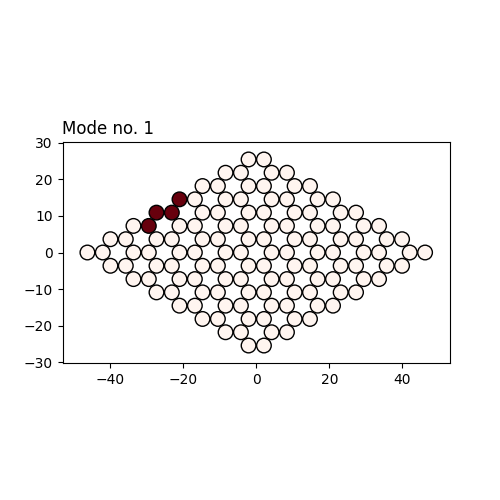

In [15]:
phi_mat = loop_FD(C_MATRIX, 5000, INIT_EXCITATION, DELTA_Z)
# phi_mat_with_driving = loop_FD_with_driving(C_MATRIX, 100000, INIT_EXCITATION, DELTA_Z, INIT_EXCITATION, +50.0, 10)
# print(phi_mat_with_driving[18,:]*np.conjugate(phi_mat_with_driving[18,:]))
# intensity_to_plot_with_driving = phi_mat_with_driving*np.conjugate(phi_mat_with_driving)#/ np.sum(phi_mat_with_driving*np.conjugate(phi_mat_with_driving), axis=0)
intensity_to_plot = phi_mat*np.conjugate(phi_mat) / np.sum(phi_mat*np.conjugate(phi_mat), axis=0)

# init_int_with_driving_start = phi_mat_with_driving[:,0]*np.conjugate(phi_mat_with_driving[:,0]) #/ np.sum(phi_mat_with_driving[:,0]*np.conjugate(phi_mat_with_driving[:,0]))
# init_int_with_driving_end = phi_mat_with_driving[:,-1]*np.conjugate(phi_mat_with_driving[:,-1]) #/ np.sum(phi_mat_with_driving[:,-1]*np.conjugate(phi_mat_with_driving[:,-1]))


# init_int_start = phi_mat[:,0]*np.conjugate(phi_mat[:,0]) / np.sum(phi_mat[:,0]*np.conjugate(phi_mat[:,0]))
# init_int_end = phi_mat[:,-1]*np.conjugate(phi_mat[:,-1]) / np.sum(phi_mat[:,-1]*np.conjugate(phi_mat[:,-1]))
# for i in range(10)
# plot_coloured_chain(init_int_with_driving_start, 4, point_list, 1)
# plot_coloured_chain(init_int_with_driving_end, 4, point_list, 1)

plot_coloured_chain(intensity_to_plot[:,0], 4, point_list, 1)
# plot_coloured_chain(init_int_end, 4, point_list, 1)

In [17]:
# loc_list =  np.array([[-2,0],[2,0]])

# name_list = []
# for i in range(np.shape(intensity_two_core)[1]):
#     fig_chain = plt.figure(figsize=(6,6))
#     ax_chain = fig_chain.add_subplot(111)

#     circ_list = []
#     norm = colors.Normalize(vmin=0, vmax=np.max(np.real(intensity_two_core[:,i])))
#     cmap = plt.cm.get_cmap('Reds')
#     cmap(norm(np.real(intensity_two_core)))
#     for j in range(len(intensity_two_core)):
#         circ_list.append(patches.Circle((loc_list[j][0], loc_list[j][1]), radius=4//2,
#                                             color=cmap(np.real(intensity_two_core[j,i])),ec='black')) 

#     plt.axis('off')
#     # Plot all circles
#     for _circ in circ_list:
#         ax_chain.add_patch(_circ)

#     plt.axis('scaled')

#     plot_name = r'C:/Users/nr421/Documents/Twisted gifs/individual images/twisted propagation plot {:.1f}.png'.format(i)
#     name_list.append(plot_name)
#     fig_chain.savefig(plot_name)
#     print(i)
#     plt.close()
# # name_list = [val for val in name_list for _ in range(2)] # This just takes images multiple times to slow down the gif
# with imageio.get_writer('C:/Users/nr421/Documents/Twisted gifs/finite difference two core driving.gif', mode='I', duration=0.001, loop=0) as writer:
#     for filename in name_list:
#         image = imageio.imread(filename)
#         writer.append_data(image)
#     writer.close()

In [ ]:
name_list = []
for i in range(np.shape(intensity_to_plot_with_driving)[1])[::100]:
    fig_chain = plt.figure(figsize=(10,10))
    ax_chain = fig_chain.add_subplot(111)

    circ_list = []
    norm = colors.Normalize(vmin=0, vmax=3.0)#np.max(np.real(intensity_to_plot_with_driving[:,i])))
    if i == 99:
        print(i)
    cmap = plt.cm.get_cmap('Reds')
    # cmap(norm(np.real(intensity_to_plot_with_driving)))
    for j in range(len(intensity_to_plot_with_driving)):
        circ_list.append(patches.Circle((point_list[j][0], point_list[j][1]), radius=2.1,
                                            color=cmap(norm(np.real(intensity_to_plot_with_driving[j,i]))),ec='black')) 

    plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)

    plt.axis('scaled')

    plot_name = r'C:/Users/nr421/Documents/Twisted gifs/individual images/twisted propagation plot {:.1f}.png'.format(i)
    name_list.append(plot_name)
    fig_chain.savefig(plot_name)
    plt.close()
# name_list = [val for val in name_list for _ in range(2)] # This just takes images multiple times to slow down the gif
with imageio.get_writer('C:/Users/nr421/Documents/Twisted gifs/finite difference magnetic driven longer lower norm.gif', mode='I', duration=0.01, loop=0) as writer:
    for filename in name_list:
        image = imageio.imread(filename)
        writer.append_data(image)
    writer.close()

In [16]:
name_list = []
for i in range(np.shape(intensity_to_plot)[1])[::10]:
    fig_chain = plt.figure(figsize=(10,10))
    ax_chain = fig_chain.add_subplot(111)

    circ_list = []
    norm = colors.Normalize(vmin=0, vmax=np.max(np.real(intensity_to_plot[:,i])))
    if i == 99:
        print(i)
    cmap = plt.cm.get_cmap('Reds')
    # cmap(norm(np.real(intensity_to_plot_with_driving)))
    for j in range(len(intensity_to_plot)):
        circ_list.append(patches.Circle((point_list[j][0], point_list[j][1]), radius=2.1,
                                            color=cmap(norm(np.real(intensity_to_plot[j,i]))),ec='black')) 

    plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)

    plt.axis('scaled')

    plot_name = r'C:/Users/nr421/Documents/Twisted gifs/individual images/twisted propagation plot {:.1f}.png'.format(i)
    name_list.append(plot_name)
    fig_chain.savefig(plot_name)
    plt.close()
# name_list = [val for val in name_list for _ in range(2)] # This just takes images multiple times to slow down the gif
with imageio.get_writer('C:/Users/nr421/Documents/Twisted gifs/finite difference magnetic no driving overlap excitation.gif', mode='I', duration=0.001, loop=0) as writer:
    for filename in name_list:
        image = imageio.imread(filename)
        writer.append_data(image)
    writer.close()

In [ ]:
print(np.block([[np.eye(4)*-1,np.zeros((4,4))],[np.zeros((4,4)),np.eye(4)]]))